In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import GridSearchCV


plt.rcParams["figure.figsize"] = (20,10)

In [4]:

def read_file(p):
    full_p = os.path.sep.join([os.getcwd(),'EmoBank-master','corpus',p])
    return pd.read_csv(full_p, delimiter='\t', quoting=3)#.set_index('id')

df_writer = read_file("writer.tsv")
df_reader = read_file("reader.tsv")
df_raw = read_file("raw.tsv")
df_meta = read_file("meta.tsv")
df_full = df_meta.merge(df_raw, on='id', suffixes=['_meta','_raw']).merge(df_writer, on='id', suffixes=['','_writer']).merge(df_reader, on='id', suffixes=['_writer','_reader']) 


In [5]:
print('writer: %d, reader: %d, raw: %d, meta: %d'%(df_writer.shape[0], df_reader.shape[0], df_raw.shape[0], df_meta.shape[0]))
print('joined data: %d'%df_full.shape[0])

writer: 10279, reader: 10325, raw: 10548, meta: 10548
joined data: 10062


In [6]:
rename_cols_dict = dict([('_'.join([a,b]),'_'.join([b,a.lower()])) for a,b in [s.split('_') for s in df_full.columns if '_' in s]])

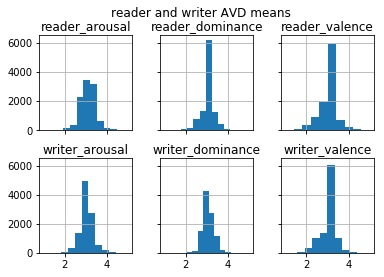

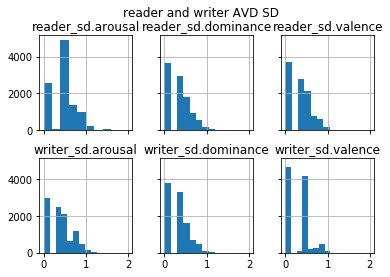

Index(['id', 'document', 'category', 'subcategory', 'sentence',
       'writer_arousal', 'writer_dominance', 'writer_valence',
       'writer_sd.arousal', 'writer_sd.dominance', 'writer_sd.valence',
       'writer_freq', 'reader_arousal', 'reader_dominance', 'reader_valence',
       'reader_sd.arousal', 'reader_sd.dominance', 'reader_sd.valence',
       'reader_freq'],
      dtype='object')


In [7]:
# lets understand how each target value behaves

df_full = df_full.rename(columns=rename_cols_dict)

df_full[[c for c in df_full.columns if ('sd' not in c and 'freq' not in c)]].hist(layout=(-1,3), sharex=True, sharey=True, bins=10, figsize=(6,4))
plt.suptitle('reader and writer AVD means')
df_full[[c for c in df_full.columns if ('sd' in c)]].hist(layout=(-1,3), sharex=True, sharey=True, bins=10, figsize=(6,4))
plt.suptitle('reader and writer AVD SD')
plt.show()
print(df_full.columns)

In [8]:
import spacy
# !python -m spacy download en
nlp = spacy.load(r'C:\Users\orc\Anaconda2\envs\intro2ml\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.0.0'.replace('\\',os.path.sep))
df_full['spacy_doc'] = df_full.sentence.apply(lambda s: nlp(s))

In [9]:
# perform different text preprocessing

import string

sentence_to_lemmas = lambda doc: [token.lemma_ for token in doc if not (token.is_stop or (token.lemma_ in string.punctuation) or (token.lemma_ == '-PRON-'))]  
sentence_to_pos = lambda doc: [token.pos_ for token in doc]
sentence_to_text = lambda doc: [token.text for token in doc]
sentence_to_lowercase = lambda doc: [token.orth_.lower() for token in doc]

df_full['lemma_list'] = df_full.spacy_doc.apply(sentence_to_lemmas)
df_full['pos_list'] = df_full.spacy_doc.apply(sentence_to_pos)
df_full['text_list'] = df_full.spacy_doc.apply(sentence_to_text)
df_full['text_lower_list'] = df_full.spacy_doc.apply(sentence_to_lowercase) 
# didn't reconstruct ents_count column

In [10]:
# train-test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_full, random_state = 0)


In [11]:
# check total data and splits 
reader_sts = pd.DataFrame([df_full.std(), train.std(), test.std()])[['reader_valence','reader_arousal','reader_dominance']]
reader_sts.index = ['all data','train set','test set']
reader_sts


,reader_valence,reader_arousal,reader_dominance
all data,0.426694,0.328904,0.285328
train set,0.427994,0.331061,0.284379
test set,0.422827,0.322214,0.288070


In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, _document_frequency
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

target_col = 'reader_valence'


def get_mse(regressor, X_train, y_train, X_test, y_test):
    train_mse = mean_squared_error(y_train, regressor.predict(X_train))
    test_mse = mean_squared_error(y_test, regressor.predict(X_test))
    return train_mse, test_mse

def grid_search(param_col, train, test, target_col, pipeline, parameters, save_prefix, cv=5):
    t0 = time()
    grid_search = GridSearchCV(pipeline, parameters, cv=cv, refit=True,
                               n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
    print("Performing grid search with %s"%param_col)
    grid_search.fit(train[param_col], train[target_col])
    print("done in %d seconds" % (time() - t0))
    print("Best parameters set:")
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, grid_search.best_estimator_.get_params()[param_name]))
    print("Best model train score: %0.3f" % mean_squared_error(grid_search.best_estimator_.predict(train[param_col]), train[target_col]))
    test_score = mean_squared_error(grid_search.best_estimator_.predict(test[param_col]), test[target_col])
    print("Best model test score: %0.3f" % test_score)
#     joblib.dump(grid_search, '%s_%s_grid_search%0.3f.pkl'% (save_prefix,param_col,test_score), compress = 1)    
    return grid_search

def merge_dicts(a, b):
    merge = {}
    for k in a.keys():
        merge[k] = set(np.array([np.array([a[k]]).flatten(),(np.array([b[k]]).flatten())]).flatten())
    return merge

def model_summary(model, grid_params, param_col):
    model_details = dict([(k,v) for (k,v) in model.get_params().items() if k in grid_params])
    model_details['preprocessing'] = param_col
    train_score = mean_squared_error(model.predict(train[param_col]), train[target_col])
    test_score = mean_squared_error(model.predict(test[param_col]), test[target_col])
    model_details['train_score'] = train_score
    model_details['test_score'] = test_score
    return model_details

def models_comparator(grid_search_result, preprocs, grid_params):
    models_comparison = []
    for preproc in preprocs:
        best_model = grid_search_result[preproc.replace('_list','')].best_estimator_
        model_details = model_summary(best_model, grid_params, preproc)
        models_comparison.append(model_details)
    return pd.DataFrame(models_comparison)

def dummy_fun(doc):    
     return doc


In [74]:
tf_ifd_pipeline = Pipeline(
    [('vect', CountVectorizer(tokenizer = dummy_fun, analyzer='word', lowercase=False, min_df=1, 
              ngram_range=(1, 1), preprocessor=None, stop_words=None, strip_accents=False)),
     ('tfidf', TfidfTransformer(smooth_idf=True)),
     ('rgs', SVR(kernel='rbf', verbose=False))
    ])

tf_idf_params_grid = {'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'tfidf__use_idf': (True, False),
 'tfidf__norm': ('l1', 'l2'),
 'rgs__gamma': ('auto', 'scale'),
 'rgs__C': (0.5, 1, 100)}
  
tf_idf_grid_search = {}
if os.path.exists('tfidf_grid_search_all.pkl'):    
    tf_idf_grid_search = joblib.load('tfidf_grid_search_all.pkl')
    print('Done loading tf_idf grid search from file')
else:
    for param_col in ['lemma_list', 'pos_list','text_list', 'text_lower_list']:
        tf_idf_grid_search[param_col.replace('_list','')] = grid_search(param_col, train[:20], test[:20], target_col, tf_ifd_pipeline, tf_idf_params_grid, 'tfidf_new', cv=5)
    joblib.dump(tf_idf_grid_search, 'tfidf_grid_search_all.pkl', compress = 1)
    print('Done performing tf_idf grid search')

# create a df comparing best models for each preproc
tf_idf_grid_params = ['rgs__C', 'rgs__gamma', 'tfidf__norm', 
                      'tfidf__use_idf', 'vect__max_df', 'vect__max_features', 'vect__ngram_range']
preprocs = ['lemma_list', 'pos_list', 'text_list', 'text_lower_list']


tf_idf_model_comparison = models_comparator(tf_idf_grid_search, preprocs, tf_idf_grid_params)

print('''
Select the best preprocessing method. Excpet for the pos, which yielded worst score on both train and test,
all other preprocessings grid searchd found the optimal solution with the same hyper parameters. This makes the selection
in the lemmatizing preprocessing even more concrete as the optiomal solution.
''')
tf_idf_model_comparison[['preprocessing', 'test_score', 'train_score','rgs__C', 'rgs__gamma', 'tfidf__norm',
       'tfidf__use_idf', 'vect__max_df', 'vect__max_features', 'vect__ngram_range']]

Done loading tf_idf grid search from file

Select the best preprocessing method. Excpet for the pos, which yielded worst score on both train and test,
all other preprocessings grid searchd found the optimal solution with the same hyper parameters. This makes the selection
in the lemmatizing preprocessing even more concrete as the optiomal solution.



,preprocessing,test_score,train_score,rgs__C,rgs__gamma,tfidf__norm,tfidf__use_idf,vect__max_df,vect__max_features,vect__ngram_range
0,lemma_list,0.138323,0.018826,100,scale,l2,True,0.50,None,"(1, 2)"
1,pos_list,0.169265,0.171063,1,scale,l2,False,0.75,None,"(1, 2)"
2,text_list,0.139707,0.023333,100,scale,l2,True,0.50,None,"(1, 2)"
3,text_lower_list,0.137354,0.022278,100,scale,l2,True,0.50,None,"(1, 2)"


In [16]:
print(tf_idf_model_comparison[['preprocessing', 'test_score', 'train_score','rgs__C', 'rgs__gamma', 'tfidf__norm',
       'tfidf__use_idf', 'vect__max_df', 'vect__max_features', 'vect__ngram_range']].to_latex())

\begin{tabular}{llrrrlllrll}
\toprule
{} &    preprocessing &  test\_score &  train\_score &  rgs\_\_C & rgs\_\_gamma & tfidf\_\_norm &  tfidf\_\_use\_idf &  vect\_\_max\_df & vect\_\_max\_features & vect\_\_ngram\_range \\
\midrule
0 &       lemma\_list &    0.138323 &     0.018826 &     100 &      scale &          l2 &            True &          0.50 &               None &            (1, 2) \\
1 &         pos\_list &    0.169265 &     0.171063 &       1 &      scale &          l2 &           False &          0.75 &               None &            (1, 2) \\
2 &        text\_list &    0.139707 &     0.023333 &     100 &      scale &          l2 &            True &          0.50 &               None &            (1, 2) \\
3 &  text\_lower\_list &    0.137354 &     0.022278 &     100 &      scale &          l2 &            True &          0.50 &               None &            (1, 2) \\
\bottomrule
\end{tabular}



In [18]:
''' Get a grid search result dict (with preprocs as keys) and return a DataFrame with params and mean test results'''
def grid_search_results_to_df(grid_search_result_dict, preprocs = ['lemma_list']):
    grid_search_results_df = None
    for preproc in preprocs:
        res = pd.DataFrame(grid_search_result_dict[preproc.replace('_list','')].cv_results_['params'])
        res['mean_test_score'] = -1 * grid_search_result_dict[preproc.replace('_list','')].cv_results_['mean_test_score']
        res['preprocessing'] = preproc
        if grid_search_results_df is None:
            grid_search_results_df = res
        else:
            grid_search_results_df = grid_search_comparator.append(res)
    return grid_search_results_df

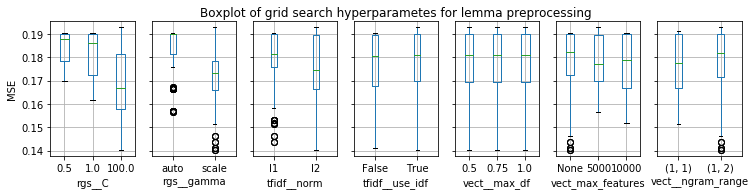

In [25]:
tf_idf_grid_search_results_df = grid_search_results_to_df(tf_idf_grid_search)
# fix None values of max_features so it gets plotted
tf_idf_grid_search_results_df['vect_max_features'] = tf_idf_grid_search_results_df.vect__max_features.apply(lambda x:x if x==x else 0.0)
param_for_plotting = ['rgs__C', 'rgs__gamma', 'tfidf__norm', 'tfidf__use_idf', 'vect__max_df',
       'vect_max_features', 'vect__ngram_range']
fig, axes = plt.subplots(1,7, figsize = (12,2.5), sharey=True)
for idx, param in enumerate(param_for_plotting):
    ax = axes[idx]
    tf_idf_grid_search_results_df.boxplot(column='mean_test_score', by=param, ax=ax)
    ax.set_title('')
axes[-2].set_xticklabels(['None','5000','10000'])
plt.suptitle('Boxplot of grid search hyperparametes for lemma preprocessing')
axes[0].set_ylabel('MSE')
plt.show()

In [114]:
df_full.reader_valence.std()**2

0.10817812307930558

In [28]:
# drill down into max_df
import numpy as np
count_vectorizer = CountVectorizer(tokenizer = dummy_fun, analyzer='word', lowercase=False, max_df=1.0, max_features=None, min_df=1, 
              ngram_range=(1, 2), preprocessor=None, stop_words=None, strip_accents=False, binary=True)
count_vectorizer.fit(train.lemma_list)

max_word = count_vectorizer.get_feature_names()[count_vectorizer.transform(train.lemma_list).sum(axis=0).argmax()]
max_word_count = count_vectorizer.transform(train.lemma_list).sum(axis=0).max()

print(
'''We try to explain the simialr distributions of the max_df hyperparameter. This hyperparameter sets the max portion of 
document frequency ngram may have - any higher value will result with ignoring the ngram. 
And indeed, the word with the maximal document frequency is %s, with document frequency of %d, which is only %%%.f of the 
sentences, meaning none of the max_df values used in the grid search had any effect on the fitting, making this 
hyperparmeter useless to fit on.
'''%(max_word,max_word_count,100*max_word_count/train.shape[0])
)

We try to explain the simialr distributions of the max_df hyperparameter. This hyperparameter sets the max portion of 
document frequency ngram may have - any higher value will result with ignoring the ngram. 
And indeed, the word with the maximal document frequency is the, with document frequency of 701, which is only %9 of the 
sentences, meaning none of the max_df values used in the grid search had any effect on the fitting, making this 
hyperparmeter useless to fit on.



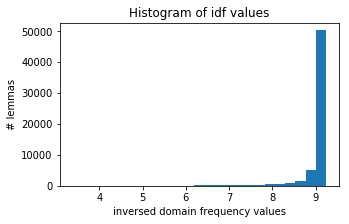

(60599,)

In [29]:
# drill down into use_idf
count_vectorizer = CountVectorizer(tokenizer = dummy_fun, analyzer='word', lowercase=False, max_df=1.0, max_features=None, min_df=1, 
              ngram_range=(1, 2), preprocessor=None, stop_words=None, strip_accents=False)
count_vectorizer.fit(train.lemma_list)

tf_idf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tf_idf_transformer.fit(count_vectorizer.transform(train.lemma_list))
plt.figure(figsize=(5,3))

plt.hist(tf_idf_transformer._idf_diag.diagonal(), bins=25)
plt.title('Histogram of idf values')
plt.xlabel('inversed domain frequency values')
plt.ylabel('# lemmas')
plt.show()
tf_idf_transformer._idf_diag.max()

tf_idf_transformer._idf_diag.diagonal().shape

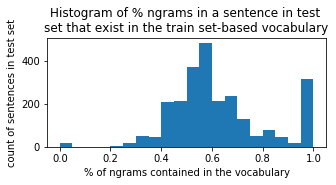

In [32]:
plt.figure(figsize=(5,2))
plt.hist(list(np.asarray(count_vectorizer.transform(test.lemma_list).sum(axis=1)).reshape(-1) / 
    test.lemma_list.apply(lambda x:2*len(x)-1)), bins=20)
plt.title('Histogram of % ngrams in a sentence in test \nset that exist in the train set-based vocabulary')
plt.xlabel('% of ngrams contained in the vocabulary')
plt.ylabel('count of sentences in test set')
plt.show()


# W2V


In [33]:
import gensim 


class Word2VecTransformer(object):
    def __init__(self, min_count=None, size=50, window=3, iter=5):
        self.min_count = min_count
        self.size = size
        self.window = window
        self.iter = iter
    
    def set_params(self, min_count, size, window, iter):
        self.min_count = min_count
        self.size = size
        self.window = window
        self.iter = iter
    
    def fit(self, X, y):
        self.model = gensim.models.Word2Vec(
        X,
        size=self.size,
        window=self.window,
        min_count=self.min_count,
        iter=self.iter)
        return self
    
    def transform(self, X):
        res = []
        for sen in X:
            w_in_wv_map = [w for w in sen if w in self.model.wv]
            if len(w_in_wv_map) > 0:
                k = np.mean(np.array([self.model.wv[w] for w in w_in_wv_map]), axis=0)
            else:
                k = np.zeros(self.size)
            res.append(k)
        return np.array(res)
        
    def get_params(self, deep=True):
        return {'min_count':self.min_count, 'size':self.size, 'window':self.window, 'iter':self.iter}
        

C:\Users\orc\Anaconda2\envs\intro2ml\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [34]:
from time import time
from sklearn.model_selection import GridSearchCV

w2v_pipeline = Pipeline([('w2v',Word2VecTransformer()),
         ('rgs', SVR(kernel='rbf', verbose=False, gamma='scale'))])

w2v_params_grid = {'w2v__min_count': (1, 3, 5),
     'w2v__size': (50, 100, 300),
     'w2v__window': (3, 5, 7),
     'w2v__iter': (5, 10),
#      'rgs__gamma': ('scale',),
     'rgs__C': (10,100,500)}
  
w2v_grid_search = {}
preprocs = ['pos_list', 'text_list', 'text_lower_list']

if os.path.exists('w2v_grid_search_all.pkl'):    
    w2v_grid_search = joblib.load('w2v_grid_search_all.pkl')
    print('Done loading w2v grid search from file')
else:
    for param_col in preprocs:
        w2v_grid_search[param_col.replace('_list','')] = grid_search(param_col, train, test, target_col, w2v_pipeline, w2v_params_grid, 'w2v', cv=5)
    joblib.dump(w2v_grid_search, 'w2v_grid_search_all.pkl', compress = 1)
    print('Done performing w2v grid search')

# create a df comparing best models for each preproc
w2v_grid_params = ['w2v__min_count','w2v__size','w2v__window','w2v__iter','rgs__gamma','rgs__C']
w2v_model_comparison = models_comparator(w2v_grid_search, preprocs, w2v_grid_params)

w2v_model_comparison[['preprocessing', 'test_score', 'train_score','w2v__min_count', 'w2v__size',
                      'w2v__window','w2v__iter','rgs__gamma','rgs__C']]

Done loading w2v grid search from file


,preprocessing,test_score,train_score,w2v__min_count,w2v__size,w2v__window,w2v__iter,rgs__gamma,rgs__C
0,pos_list,0.196350,0.201557,5,300,5,10,scale,100
1,text_list,0.195540,0.201051,5,100,3,5,scale,10
2,text_lower_list,0.194673,0.200050,5,50,7,10,scale,10


In [36]:
print(w2v_model_comparison[['preprocessing', 'test_score', 'train_score','w2v__min_count', 'w2v__size',
                      'w2v__window','w2v__iter','rgs__gamma','rgs__C']].to_latex())

\begin{tabular}{llrrrrrrlr}
\toprule
{} &    preprocessing &  test\_score &  train\_score &  w2v\_\_min\_count &  w2v\_\_size &  w2v\_\_window &  w2v\_\_iter & rgs\_\_gamma &  rgs\_\_C \\
\midrule
0 &         pos\_list &    0.196350 &     0.201557 &               5 &        300 &            5 &         10 &      scale &     100 \\
1 &        text\_list &    0.195540 &     0.201051 &               5 &        100 &            3 &          5 &      scale &      10 \\
2 &  text\_lower\_list &    0.194673 &     0.200050 &               5 &         50 &            7 &         10 &      scale &      10 \\
\bottomrule
\end{tabular}



In [38]:
print(pd.DataFrame([w2v_params_grid,]).to_latex())
pd.DataFrame([w2v_params_grid,])

\begin{tabular}{llllll}
\toprule
{} &          rgs\_\_C & w2v\_\_iter & w2v\_\_min\_count &       w2v\_\_size & w2v\_\_window \\
\midrule
0 &  (10, 100, 500) &   (5, 10) &      (1, 3, 5) &  (50, 100, 300) &   (3, 5, 7) \\
\bottomrule
\end{tabular}



,rgs__C,w2v__iter,w2v__min_count,w2v__size,w2v__window
0,"(10, 100, 500)","(5, 10)","(1, 3, 5)","(50, 100, 300)","(3, 5, 7)"


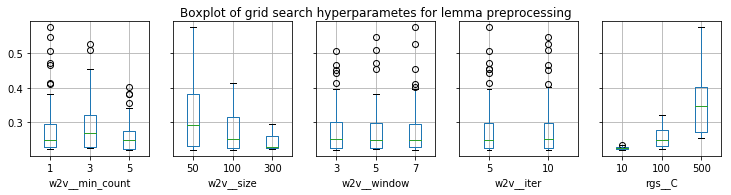

In [40]:
import pandas as pd
w2v_grid_search_results_df = grid_search_results_to_df(w2v_grid_search, preprocs=['text_lower_list'])


param_for_plotting = w2v_params_grid.keys()
fig, axes = plt.subplots(1,5, figsize = (12,2.5), sharey=True)
for idx, param in enumerate(param_for_plotting):
    ax = axes[idx]
    w2v_grid_search_results_df.boxplot(column='mean_test_score', by=param, ax=ax)
    ax.set_title('')
plt.suptitle('Boxplot of grid search hyperparametes for lemma preprocessing')
plt.show()


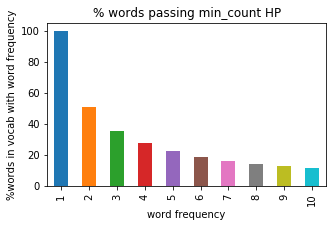

In [158]:
import numpy as np
words_counter_train_fit = CountVectorizer(tokenizer = dummy_fun, analyzer='word', lowercase=False, min_df=1, 
              ngram_range=(1, 1), preprocessor=None, stop_words=None, strip_accents=False).fit_transform(train.text_lower_list)
counts = np.asarray(words_counter_train_fit.sum(axis=0)).reshape(-1)
def d_up_to_x(d, x=10):
    if d>=x: return x
    return d
s = pd.Series([d_up_to_x(d) for d in counts])
vc = (s.value_counts()/len(s)*100).sort_index()
vc_cumsum = vc[::-1].cumsum()[::-1]
vc_cumsum.plot(kind='bar', figsize=(5,3))
plt.title('% words passing min_count HP')
plt.xlabel('word frequency')
plt.ylabel('%words in vocab with word frequency')
plt.show()

In [44]:
import gensim.downloader as api

w2v_model = api.load('word2vec-google-news-300')

In [45]:
def sent_to_vec(ll, dim=300):
    w_in_wv_map = [w for w in ll if w in w2v_model]
    if len(w_in_wv_map) > 0:
        k = np.mean(np.array([w2v_model[w] for w in w_in_wv_map]), axis=0)
    else:
        k = np.zeros(dim)
    return k

def col_to_w2v(col_values):
    return np.array([np.array(v) for v in col_values.apply(sent_to_vec).values])
train_text_list_w2v = col_to_w2v(train.text_list)
train_text_lower_list_w2v = col_to_w2v(train.text_lower_list)
train_lemma_list_w2v = col_to_w2v(train.lemma_list)

test_text_list_w2v = col_to_w2v(test.text_list)
test_text_lower_list_w2v = col_to_w2v(test.text_lower_list)
test_lemma_list_w2v = col_to_w2v(test.lemma_list)

# grid_search.fit(train[param_col], train[target_col])
# m = SVR(kernel='rbf', verbose=False, gamma='scale').fit(d, np.array(train[target_col].values))


In [46]:

w2v_pretrained_params_grid = {'rgs__gamma': ('scale','auto'),
     'rgs__C': (1,10,100)}

w2v_pretrained_grid_search = {}
preprocs = ['lemma_list', 'text_list', 'text_lower_list']

def mini_grid_search(X, y, parameters):
    pipeline = Pipeline([('rgs', SVR(kernel='rbf', verbose=False, gamma='scale'))])
    gs = GridSearchCV(pipeline, parameters, cv=5, refit=True,
                           n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
    return gs.fit(X, y)

if os.path.exists('w2v_pretrained_grid_search_all.pkl'):    
    w2v_pretrained_grid_search = joblib.load('w2v_pretrained_grid_search_all.pkl')
    print('Done loading w2v pretrained grid search from file')
else:
    w2v_pretrained_grid_search['text_list'] = mini_grid_search(train_text_list_w2v, train[target_col], w2v_pretrained_params_grid)
    w2v_pretrained_grid_search['text_lower_list'] = mini_grid_search(train_text_lower_list_w2v, train[target_col], w2v_pretrained_params_grid) 
    w2v_pretrained_grid_search['lemma_list'] = mini_grid_search(train_lemma_list_w2v, train[target_col], w2v_pretrained_params_grid)
    joblib.dump(w2v_pretrained_grid_search, 'w2v_pretrained_grid_search_all.pkl', compress = 1)
    print('Done performing w2v grid search')
w2v_pretrained_grid_search['text'] = w2v_pretrained_grid_search['text_list']
w2v_pretrained_grid_search['text_lower'] = w2v_pretrained_grid_search['text_lower_list']
w2v_pretrained_grid_search['lemma'] = w2v_pretrained_grid_search['lemma_list']


models_comparison = []
train_X = {'text_list':train_text_list_w2v, 'text_lower_list':train_text_lower_list_w2v, 'lemma_list':train_lemma_list_w2v}
test_X = {'text_list':test_text_list_w2v, 'text_lower_list':test_text_lower_list_w2v, 'lemma_list':test_lemma_list_w2v}

for preproc in preprocs:
    model = w2v_pretrained_grid_search[preproc.replace('_list','')].best_estimator_
    model_details = dict([(k,v) for (k,v) in model.get_params().items() if k in w2v_pretrained_params_grid.keys()])
    model_details['preprocessing'] = preproc
    model_details['train_score'] = mean_squared_error(model.predict(train_X[preproc]), train[target_col])
    model_details['test_score'] = mean_squared_error(model.predict(test_X[preproc]), test[target_col])
#     model_details = pd.DataFrame(model_details)
    models_comparison.append(model_details)
w2v_pretrained_model_comparison = pd.DataFrame(models_comparison)


w2v_pretrained_model_comparison[['preprocessing', 'test_score', 'train_score','rgs__gamma','rgs__C']]
# need to try embedding with this w2v
# w2v_model

Done loading w2v pretrained grid search from file


,preprocessing,test_score,train_score,rgs__gamma,rgs__C
0,lemma_list,0.121801,0.089756,scale,10
1,text_list,0.122627,0.094024,scale,10
2,text_lower_list,0.121023,0.096399,scale,10


In [47]:
print(w2v_pretrained_model_comparison[['preprocessing', 'test_score', 'train_score','rgs__gamma','rgs__C']].to_latex())

\begin{tabular}{llrrlr}
\toprule
{} &    preprocessing &  test\_score &  train\_score & rgs\_\_gamma &  rgs\_\_C \\
\midrule
0 &       lemma\_list &    0.121801 &     0.089756 &      scale &      10 \\
1 &        text\_list &    0.122627 &     0.094024 &      scale &      10 \\
2 &  text\_lower\_list &    0.121023 &     0.096399 &      scale &      10 \\
\bottomrule
\end{tabular}



# Task-specific Encoding

In [ ]:
'''Although corpus-statistics-based encoding is a common approach for such regression problem, since the specific 
VAD problem is well-researched, we can try leverage recent results in this task.
In his paper, Ahmad (https://saifmohammad.com/WebPages/nrc-vad.html) built a 20k words english vocabulary with 
annotated VAD values. We will address it as NRC-VAD dataset. We can use it's values to encode words of sentences in our dataset.
We address two design decisions when encoding:
1. Treating out-of-vocabulary words: 
Although it is the largest VAD annotated dataset published so of today, we can expect many words from our dataset to be missing 
from it. Instead of treating this problem with a common approach of the same "default" value returned for every missing word,
we will try to predict the missing word values. We will do this by utilizing a pretrained word2vec model in order to 
find the missing word K nearset neighbors, and assigning the missing word with a vlue based on it's neighbors annotation.
As a perliminary step, we will find the best K by doing a grid search.
2. Aggregating sentence's words encoding to a single vector:
This is a common problem when using encodings of varying-length element, such as word2vec of a sentence's words.
There are several approaches to this, like averaging  min\max-pool per dimension. Usually it is hard to give interpertation
as to why a specific method is better than the other - we will try to explain different results.'''

## Treating out-of-vocabulary words


First, we would choose one preprocessing to focus on. We could do the whole process for every encoding (thus adding a 
'preprocessing' dimension to the grid search), but in this case we can apply some simple reasoning for selecting a spcific
encoding. Below are the elements (lemma \ word \ lower cased word) in our train set distribution over the 2 vocabularies -
the NRC from which we will get word encoding, and the w2v from which we will is vector space representation to estimate
NRC values of words missing from the NRC vocabulary. Our main goal is to choose a preprocessing that minimizes the words 
that don't have encoding at all, either direct from the NRC or estimated by KNN on w2v over NRC.
With this condition in mind, we will choose the simple text preprocessing, since it has 7% of words that do not appear in
NRC nor in the W2V vocab. The downside of this preprocessing is the fact that only 38% of the words are represented in the
NRC vocab, while the other preprocessings has 46% 

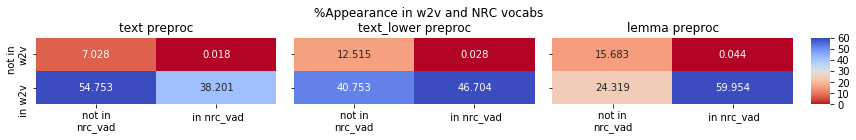

In [56]:
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

# load nrc scores into dict
nrc_vad_df = pd.read_csv(r'C:\Users\orc\Google Drive\MSc\ml_applications\NRC-VAD-Lexicon.txt', sep='\t')
nrc_vad = dict([(r.Word,{'v':r.Valence, 'a':r.Arousal, 'd':r.Dominance}) for i,r in nrc_vad_df.iterrows()])

# fig, axes = plt.subplots(1,3)
def counts_to_heatmap(vals, ax, title, cbar = False, cbar_ax=None):
    ll = set(itertools.chain(*vals))
    in_w2v_vocab = [int(l in w2v_model.vocab) for l in ll]
    in_nrc_vocab = [int(l in nrc_vad) for l in ll]
    cm = confusion_matrix(in_w2v_vocab, in_nrc_vocab) / len(ll) * 100
    g = sns.heatmap(cm, annot=True, ax = ax, cbar=cbar, cbar_ax=cbar_ax, fmt='.3f', cmap='coolwarm_r'); #annot=True to annotate cells
    g.set_ylabel('')
    g.set_xlabel('')
    # labels, title and ticks
#     ax.set_title('%%Appearance of %s preprocessing \nin w2v and NRC vocabs'%title); 
    ax.set_title('%s preproc'%title); 
    ax.set_xticklabels(['not in\nnrc_vad', ' in nrc_vad']); 
    return g

f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]}, figsize = (12,2))

ax1.get_shared_y_axes().join(ax2,ax3)
g1 = counts_to_heatmap(train.text_list.values, ax1, 'text')
ax1.set_yticklabels(['not in\nw2v', 'in w2v']); 
g2 = counts_to_heatmap(train.text_lower_list.values, ax2, 'text_lower')
ax2.set_yticklabels(['', '']); 
g3 = counts_to_heatmap(train.lemma_list.values, ax3, 'lemma', cbar=True, cbar_ax=axcb)
ax3.set_yticklabels(['', '']); 
plt.suptitle('%Appearance in w2v and NRC vocabs')
f.tight_layout(rect=[0, 0.03, 1, 0.95])

print('''
First, we would choose one preprocessing to focus on. We could do the whole process for every encoding (thus adding a 
'preprocessing' dimension to the grid search), but in this case we can apply some simple reasoning for selecting a spcific
encoding. Below are the elements (lemma \ word \ lower cased word) in our train set distribution over the 2 vocabularies -
the NRC from which we will get word encoding, and the w2v from which we will is vector space representation to estimate
NRC values of words missing from the NRC vocabulary. Our main goal is to choose a preprocessing that minimizes the words 
that don't have encoding at all, either direct from the NRC or estimated by KNN on w2v over NRC.
With this condition in mind, we will choose the simple text preprocessing, since it has 7% of words that do not appear in
NRC nor in the W2V vocab. The downside of this preprocessing is the fact that only 38% of the words are represented in the
NRC vocab, while the other preprocessings has 46% and 60% of the words in the NRC vocab, meaning in this selection we will
need to estimate more words with the KNN on w2v over NRC.
''')
plt.show()

In [51]:
import gensim.downloader as api
import itertools
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import pandas as pd


ll = set(itertools.chain(*train.text_list.values))

# wrap the w2v with a 
def get_from_model(w, m):
    if w in m.wv:
        return m.wv[w]
    else:
        return np.zeros(300)

# build vector representation lists of annotated and unannotated words
knn_X_labeled = np.array([get_from_model(l,w2v_model) for l in ll if (l in nrc_vad)])

def knn_grid_search_enricher(knn_X_labeled, knn_train_value, knn_params):
    knn_reg_model = KNeighborsRegressor() 
    grid_search = GridSearchCV(knn_reg_model, knn_params, cv=5, refit=True,
                              n_jobs=-1, verbose=1)
    return grid_search.fit(knn_X_labeled, knn_train_value)    

knn_params = {'n_neighbors' : [1,3,5,20, 50], 'weights': ['uniform','distance']}

if os.path.exists('knn_v_gridsearch_results.pkl'):    
    knn_v_gridsearch_results = joblib.load('knn_v_gridsearch_results.pkl')
    print('Done loading knn_v_gridsearch_results')
else:
    knn_train_value_v = [nrc_vad[l]['v'] for l in ll if l in nrc_vad]
    knn_v_gridsearch_results = knn_grid_search_enricher(knn_X_labeled, knn_train_value_v, knn_params)
    joblib.dump(knn_v_gridsearch_results, 'knn_v_gridsearch_results.pkl', compress = 1)

if os.path.exists('knn_a_gridsearch_results.pkl'):
    knn_a_gridsearch_results = joblib.load('knn_a_gridsearch_results.pkl')
    print('Done loading knn_a_gridsearch_results')
else:
    knn_train_value_a = [nrc_vad[l]['a'] for l in ll if l in nrc_vad]
    knn_a_gridsearch_results = knn_grid_search_enricher(knn_X_labeled, knn_train_value_a, knn_params)
    joblib.dump(knn_a_gridsearch_results, 'knn_a_gridsearch_results.pkl', compress = 1)

if os.path.exists('knn_d_gridsearch_results.pkl'):
    knn_d_gridsearch_results = joblib.load('knn_d_gridsearch_results.pkl')
    print('Done loading knn_d_gridsearch_results')
else:
    knn_train_value_d = [nrc_vad[l]['d'] for l in ll if l in nrc_vad]
    knn_d_gridsearch_results = knn_grid_search_enricher(knn_X_labeled, knn_train_value_d, knn_params)
    joblib.dump(knn_d_gridsearch_results, 'knn_d_gridsearch_results.pkl', compress = 1)


C:\Users\orc\Anaconda2\envs\intro2ml\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':
C:\Users\orc\Anaconda2\envs\intro2ml\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]


Done loading knn_v_gridsearch_results
Done loading knn_a_gridsearch_results
Done loading knn_d_gridsearch_results


In [52]:
def get_enricher_df_summary(knn_x_enricher, vad_dimension):
    return pd.DataFrame([{'dimension':vad_dimension,'mean_test_score':score, 'std_test_score':std, 'n_neighbors': nei['n_neighbors'], 'weights': nei['weights']} for score,std,nei in list(zip(knn_x_enricher.cv_results_['mean_test_score'],knn_x_enricher.cv_results_['std_test_score'],knn_x_enricher.cv_results_['params']))])

v_best_params = knn_v_gridsearch_results.best_estimator_.get_params()
v_best_params['dimension']='Valence'
v_best_params['score'] = knn_v_gridsearch_results.best_score_
a_best_params = knn_a_gridsearch_results.best_estimator_.get_params()
a_best_params['dimension']='Arousal'
a_best_params['score'] = knn_a_gridsearch_results.best_score_
d_best_params = knn_d_gridsearch_results.best_estimator_.get_params()
d_best_params['dimension']='Dominance'
d_best_params['score'] = knn_d_gridsearch_results.best_score_

print(f'''In order to determine optimal KNN setup for a each dimesion, we performed a grid search over the following options:
{knn_params}
For each of the dimensions we got the following optimal hyperparameters; Note that unlike other scores addressed so far,
here the KNN estimatoin results is scored using R^2 score, thus we aim to maximize it, with 1 being the maximum value; The
fact that we get a value higher than 0 means we are doing better than the naive model of returning the average value,
meaning the assumption w2v idea of similarity between words express, amongs other things, a similarity in VAD characteristics
of words.
''')
pd.DataFrame([v_best_params, a_best_params, d_best_params])[['dimension','n_neighbors','weights','score']]

In order to determine optimal KNN setup for a each dimesion, we performed a grid search over the following options:
{'n_neighbors': [1, 3, 5, 20, 50], 'weights': ['uniform', 'distance']}
For each of the dimensions we got the following optimal hyperparameters; Note that unlike other scores addressed so far,
here the KNN estimatoin results is scored using R^2 score, thus we aim to maximize it, with 1 being the maximum value; The
fact that we get a value higher than 0 means we are doing better than the naive model of returning the average value,
meaning the assumption w2v idea of similarity between words express, amongs other things, a similarity in VAD characteristics
of words.



,dimension,n_neighbors,weights,score
0,Valence,5,distance,0.479848
1,Arousal,5,distance,0.325044
2,Dominance,20,distance,0.403666


In [53]:
print(pd.DataFrame([v_best_params, a_best_params, d_best_params])[['dimension','n_neighbors','weights','score']].to_latex())

\begin{tabular}{llrlr}
\toprule
{} &  dimension &  n\_neighbors &   weights &     score \\
\midrule
0 &    Valence &            5 &  distance &  0.479848 \\
1 &    Arousal &            5 &  distance &  0.325044 \\
2 &  Dominance &           20 &  distance &  0.403666 \\
\bottomrule
\end{tabular}



In [60]:
# Create a dict that will assist encoding sentences using the NRC encoding, by estimating VAD values for words missing
# from NRC vocab

if os.path.exists('nrc_vad_est.pkl'):
    nrc_vad_est = joblib.load('nrc_vad_est.pkl')
    print('Done loading nrc_vad_est')
else:
    # # iterate over missing words and add their estimated values
    knn_X_not_labeled = np.array([get_from_model(l,w2v_model) for l in ll if (l not in nrc_vad)])
    missing_words = [l for l in ll if (l not in nrc_vad)]
    missing_v = knn_v_gridsearch_results.best_estimator_.predict(knn_X_not_labeled)
    missing_a = knn_a_gridsearch_results.best_estimator_.predict(knn_X_not_labeled)
    missing_d = knn_d_gridsearch_results.best_estimator_.predict(knn_X_not_labeled)

    nrc_vad_est = dict([(w,{'v':v, 'a':a, 'd':d}) for w,v,a,d in zip(missing_words, missing_v, missing_a, missing_d)])
    nrc_vad_est.update(nrc_vad)
    # we build our dict based on the words in the training set; We still might encounter words in the test set that do not have
    # a mapping, since they didn't appear in the train set; Add these words to the nrc_vad_est

    ll_test = set(itertools.chain(*test.text_list.values))
    knn_X_not_labeled_test = np.array([get_from_model(l,w2v_model) for l in ll_test if (l not in nrc_vad_est)])
    missing_words_test = [l for l in ll_test if (l not in nrc_vad_est)]
    missing_v_test = knn_v_gridsearch_results.best_estimator_.predict(knn_X_not_labeled_test)
    missing_a_test = knn_a_gridsearch_results.best_estimator_.predict(knn_X_not_labeled_test)
    missing_d_test = knn_d_gridsearch_results.best_estimator_.predict(knn_X_not_labeled_test)
    nrc_vad_est_test = dict([(w,{'v':v, 'a':a, 'd':d}) for w,v,a,d in zip(missing_words_test, missing_v_test, 
                                                                          missing_a_test, missing_d_test)])
    nrc_vad_est.update(nrc_vad_est_test)
    joblib.dump(nrc_vad_est, 'nrc_vad_est.pkl', compress = 1)


Done loading nrc_vad_est


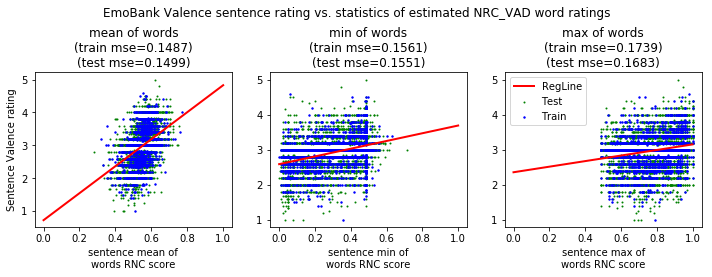

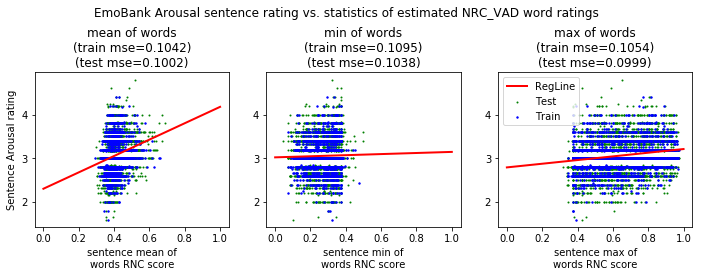

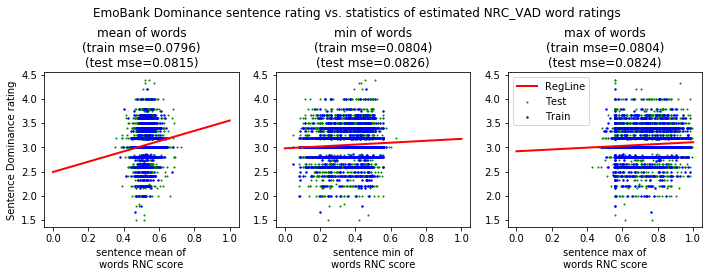

In [61]:
from sklearn import linear_model

# First we would try use the NRC values to directly preidct the 
def get_word_list_stats(word_list, nrc_vad_est, dimension):
    nrc_scores = [nrc_vad_est[w][dimension] for w in word_list]
    return {'mean':np.mean(nrc_scores), 'median':np.median(nrc_scores), 'min':np.min(nrc_scores), 'max':np.max(nrc_scores), 'std':np.std(nrc_scores)}


def plot_emo_vs_nrc_statistics(dimension, nrc_vad_est, train_reader_x, test_reader_x, dimension_full):
    fig, axes = plt.subplots(1,3,figsize=(10,4))
    X_train_all = train.text_list.apply(lambda s: get_word_list_stats(s, nrc_vad_est, dimension)).values
    X_test_all = test.text_list.apply(lambda s: get_word_list_stats(s, nrc_vad_est, dimension)).values
    for idx, stat in enumerate(['mean','min','max']):
        ax = axes[idx]
        X_train = np.array([x[stat] for x in X_train_all]).reshape(-1,1)
        X_test = np.array([x[stat] for x in X_test_all]).reshape(-1,1)
        ax.scatter(X_train, train_reader_x, s=1, c='g')
        ax.scatter(X_test, test_reader_x, s=2, c='b')
        ax.set_xlabel(f'sentence {stat} of\nwords RNC score')        
        model = linear_model.LinearRegression()
        model.fit(X_train, train_reader_x)
        y_pred =  model.predict([[0],[1]])
        train_mse = mean_squared_error(model.predict(X_train.reshape(-1, 1)), train_reader_x)
        test_mse = mean_squared_error(model.predict(X_test.reshape(-1, 1)), test_reader_x)
        ax.plot([0,1], y_pred, color='red', linewidth=2)
        ax.set_title('%s of words\n(train mse=%.4f)\n(test mse=%.4f)'%(stat, train_mse, test_mse))            
    axes[0].set_ylabel(f'Sentence {dimension_full} rating')
    axes[2].legend(['RegLine','Test','Train'])
    plt.suptitle(f'EmoBank {dimension_full} sentence rating vs. statistics of estimated NRC_VAD word ratings')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])



plot_emo_vs_nrc_statistics('v', nrc_vad_est, train.reader_valence, test.reader_valence, 'Valence')
plot_emo_vs_nrc_statistics('a', nrc_vad_est, train.reader_arousal, test.reader_arousal, 'Arousal')
plot_emo_vs_nrc_statistics('d', nrc_vad_est, train.reader_dominance, test.reader_dominance, 'Dominance')
plt.show()

In [62]:
'''We can treat all the statistics (mean, max, min, std) for every dimension as a list of features. We will try to use these
features with an interpertable model - a simple decision tree (DT)'''

from sklearn.preprocessing import StandardScaler

# create features representation for text_list
def extract_nrc_stats(text_list):
    df_v = pd.DataFrame(text_list.apply(lambda s: get_word_list_stats(s, nrc_vad_est, 'v')).tolist())
    df_v = df_v.rename(columns = dict([(c,'v_'+c) for c in df_v.columns]))
    df_a = pd.DataFrame(text_list.apply(lambda s: get_word_list_stats(s, nrc_vad_est, 'a')).tolist())
    df_a = df_a.rename(columns = dict([(c,'a_'+c) for c in df_a.columns]))
    df_d = pd.DataFrame(text_list.apply(lambda s: get_word_list_stats(s, nrc_vad_est, 'd')).tolist())
    df_d = df_d.rename(columns = dict([(c,'d_'+c) for c in df_d.columns]))
    df_train = pd.concat([df_v, df_a, df_d], axis=1)
    return df_train

train_nrc_stats = extract_nrc_stats(train.text_list)
scaler = StandardScaler()
train_nrc_stats_scaled = scaler.fit_transform(train_nrc_stats)
test_nrc_stats = extract_nrc_stats(test.text_list)
test_nrc_stats_scaled = scaler.transform(test_nrc_stats)

In [64]:
# train a decision tree and Adaboost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

rf_nrc_vad = DecisionTreeRegressor(max_depth=5).fit(train_nrc_stats, train[target_col])
adaboost_nrc_vad = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3), n_estimators=50, 
                                     learning_rate=1.0, loss='linear', random_state=0).fit(train_nrc_stats, train[target_col])
params_grid = {'gamma': ('auto', 'scale'), 'C': (0.5, 1, 100)}
svm_nrc_vad_grid_search = GridSearchCV(SVR(kernel='rbf', verbose=False), params_grid, cv=5, refit=True,
                           n_jobs=-1, verbose=1, scoring='neg_mean_squared_error').fit(train_nrc_stats_scaled, train[target_col])
# svm_nrc_vad = SVR(kernel='rbf', verbose=False).fit(train_nrc_stats, train[target_col])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.0min finished


In [65]:
def model_summary_DT(model, model_name, params, test_samples, train_samples):
    model_details = dict([(k,v) for (k,v) in model.get_params().items() if k in params])
    model_details['train_score'] = mean_squared_error(model.predict(train_samples), train[target_col])
    model_details['test_score'] = mean_squared_error(model.predict(test_samples), test[target_col])
    model_details['model'] = model_name
    return model_details
rf_summary = model_summary_DT(rf_nrc_vad, 'DecisionTree', ['max_depth'], test_nrc_stats, train_nrc_stats)
adaboost_summary = model_summary_DT(adaboost_nrc_vad, 'AdaBoost', [], test_nrc_stats, train_nrc_stats)
svm_summary = model_summary_DT(svm_nrc_vad_grid_search.best_estimator_, 'SVM', ['gamma','C'], test_nrc_stats_scaled, train_nrc_stats_scaled)
nrc_based_model_comparison = pd.DataFrame([rf_summary, adaboost_summary, svm_summary])
nrc_based_model_comparison

,C,gamma,max_depth,model,test_score,train_score
0,NaN,NaN,5.0,DecisionTree,0.143816,0.131686
1,NaN,NaN,NaN,AdaBoost,0.138693,0.135012
2,0.5,scale,NaN,SVM,0.138060,0.118386


In [66]:
print(nrc_based_model_comparison.to_latex())

\begin{tabular}{lrlrlrr}
\toprule
{} &    C &  gamma &  max\_depth &         model &  test\_score &  train\_score \\
\midrule
0 &  NaN &    NaN &        5.0 &  DecisionTree &    0.143816 &     0.131686 \\
1 &  NaN &    NaN &        NaN &      AdaBoost &    0.138693 &     0.135012 \\
2 &  0.5 &  scale &        NaN &           SVM &    0.138060 &     0.118386 \\
\bottomrule
\end{tabular}



C:\Users\orc\Anaconda2\envs\intro2ml\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,model,encoding,preprocessing,train_score,test_score
2,SVM,pretrained_word2vec,text_lower_list,0.096399,0.121023
0,SVM,pretrained_word2vec,lemma_list,0.089756,0.121801
1,SVM,pretrained_word2vec,text_list,0.094024,0.122627
3,SVM,tf-idf,text_lower_list,0.022278,0.137354
2,SVM,nrc_stats,text_list,0.118386,0.138060
0,SVM,tf-idf,lemma_list,0.018826,0.138323
1,AdaBoost,nrc_stats,text_list,0.135012,0.138693
2,SVM,tf-idf,text_list,0.023333,0.139707
0,DecisionTree,nrc_stats,text_list,0.131686,0.143816
1,SVM,tf-idf,pos_list,0.171063,0.169265


 We can look into the simple decision tree we've trained, and examine the decisions it made. Observing a 
decision tree trained on the same data with max_depth=3 will give the same results, since the first 3 splits would 
be the same (since all splitting parameters are the same). 
We can see that the Valence-related values are the ones selected at each of the first 3 splits - and with great correlatoin
with the value of the leaves (if a value is higher than a selected cut-off of v-min/mean/max, it will end up in a leaf with
a higher value.
Note that the split criterion of the regression tree is mse, which is the metric we chose to work on, thus the fitted tree
is optimized according to our target.



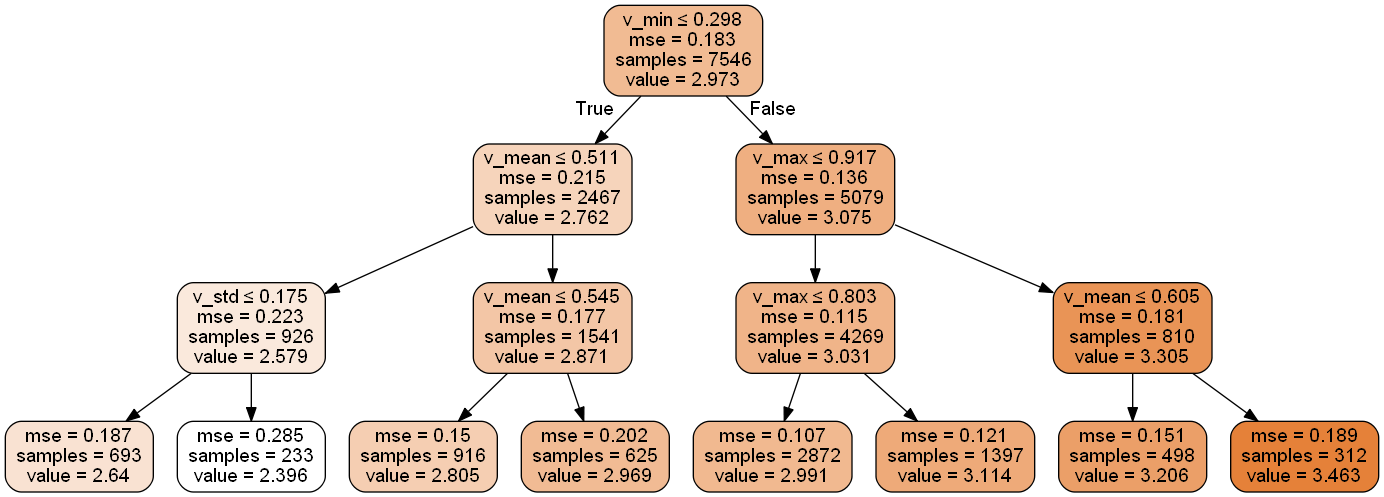

In [81]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import os
# add graphviz to path
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

rf_nrc_vad = DecisionTreeRegressor(max_depth=3)  
rf_nrc_vad.fit(train_nrc_stats, train[target_col])
dot_data = StringIO()
export_graphviz(rf_nrc_vad, out_file=dot_data,  
                feature_names = train_nrc_stats.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
print(''' We can look into the simple decision tree we've trained, and examine the decisions it made. Observing a 
decision tree trained on the same data with max_depth=3 will give the same results, since the first 3 splits would 
be the same (since all splitting parameters are the same). 
We can see that the Valence-related values are the ones selected at each of the first 3 splits - and with great correlatoin
with the value of the leaves (if a value is higher than a selected cut-off of v-min/mean/max, it will end up in a leaf with
a higher value.
Note that the split criterion of the regression tree is mse, which is the metric we chose to work on, thus the fitted tree
is optimized according to our target.
''')

Image(graph.create_png())

In [ ]:
#get all representations of text (tf-idf (PCA'd to 20), w2v pretrained (PCA'd to 20), nrc encoding (original 15)), 
# concat them to a features vector and fit on a SVR
# consider training w2v.concat(nrc_encoding) on LSTM

## prepare dimension-reduced versions of train and test set

In [71]:
# tf_idf; need to go through the 2 transformation in the pipeline, the tf and the idf
from sklearn.decomposition import TruncatedSVD, PCA
tf_idf_train = tf_idf_grid_search['lemma'].best_estimator_.steps[0][1].transform(train.lemma_list)
tf_idf_train = tf_idf_grid_search['lemma'].best_estimator_.steps[1][1].transform(tf_idf_train)
tf_idf_test = tf_idf_grid_search['lemma'].best_estimator_.steps[0][1].transform(test.lemma_list)
tf_idf_test = tf_idf_grid_search['lemma'].best_estimator_.steps[1][1].transform(tf_idf_test)
pca = TruncatedSVD(n_components=20)
tf_idf_train_lsa = pca.fit_transform(tf_idf_train)
tf_idf_test_lsa = pca.transform(tf_idf_test)

# trained word2vec
w2v_train = w2v_grid_search['text_lower'].best_estimator_.steps[0][1].transform(train.text_lower_list)
w2v_test = w2v_grid_search['text_lower'].best_estimator_.steps[0][1].transform(test.text_lower_list)
pca = PCA(n_components=20)
w2v_train_pca = pca.fit_transform(w2v_train)
w2v_test_pca = pca.transform(w2v_test)

# pretrained word2vec - these are already ready (as no fitting is made, not participating in the grid search)
pca = PCA(n_components=50)
w2v_pretrained_train_pca = pca.fit_transform(train_text_lower_list_w2v)
w2v_pretrained_test_pca = pca.transform(test_text_lower_list_w2v)

# task specific encoding - already ready, won't reduce domension (only 1X15 per sample)
train_nrc_stats_scaled
test_nrc_stats_scaled

train_all_encodings = np.concatenate([tf_idf_train_lsa, w2v_train_pca, w2v_pretrained_train_pca, train_nrc_stats_scaled], axis=1)
test_all_encodings = np.concatenate([tf_idf_test_lsa, w2v_test_pca, w2v_pretrained_test_pca, test_nrc_stats_scaled], axis=1)
train_all_encodings.shape, test_all_encodings.shape

((7546, 105), (2516, 105))

In [72]:
# grid search a simple SVM as a benchmark
params_grid = {'gamma': ('auto', 'scale'), 'C': (0.5, 1, 10, 100)}
svm_all_grid_search = GridSearchCV(SVR(kernel='rbf', verbose=False), params_grid, cv=5, refit=True,
                n_jobs=-1, verbose=1, scoring='neg_mean_squared_error').fit(train_all_encodings, train[target_col])
svm_all_summary = model_summary_DT(svm_all_grid_search.best_estimator_, 'SVM', ['gamma','C'], test_all_encodings, train_all_encodings)
pd.DataFrame([svm_all_summary])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.8min finished


,C,gamma,model,test_score,train_score
0,10,auto,SVM,0.119605,0.101752


# LSTM

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import numpy as np


# creating an embedding layer that uses predefined embeddings for words
# adapted from https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
embedding_dim = w2v_model.vector_size
hidden_dim = 32
# create a vocab and word2id dict
vocab = list(set(itertools.chain(*train.text_list.values)).union(set(itertools.chain(*test.text_list.values))))
word2id = dict([(w, int(idx)) for idx, w in enumerate(vocab)])
matrix_len = len(vocab)
weights_matrix = np.zeros((matrix_len, embedding_dim))
for i, word in enumerate(vocab):
    try: 
        weights_matrix[i] = w2v_model[word]
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(w2v_model.vector_size, ))
weights_matrix = torch.from_numpy(weights_matrix)
    
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim


class LSTMRegressor(nn.Module):

    def __init__(self, weights_matrix, hidden_dim):
        super(LSTMRegressor, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.batch_size = 1
        self.word_embeddings, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        self.out = nn.Linear(hidden_dim, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        #print('embeds', embeds.shape)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        #print('lstm_out', lstm_out.shape)
        y_pred = self.out(lstm_out[-1].view(self.batch_size, -1)) # take only the last output of LSTM
        return y_pred.view(-1)


In [29]:
train_texts = train.text_list.apply(lambda tl: np.array([int(word2id[w]) for w in tl]))
train_texts = [torch.LongTensor(v) for v in train_texts.values]
test_texts = test.text_list.apply(lambda tl: [word2id[w] for w in tl])
test_texts = [torch.LongTensor(v) for v in test_texts.values]


In [30]:
model = LSTMRegressor(weights_matrix, hidden_dim=hidden_dim)

In [32]:
from sklearn.metrics import mean_squared_error

target_col = 'reader_valence'

def get_model_stats():
    with torch.no_grad():
    #     inputs = prepare_sequence(training_data[0][0], vocab)
        train_preds = [pred.item() for pred in [model(t) for t in train_texts]]
        test_preds = [pred.item() for pred in [model(t) for t in test_texts]]

        model_details = {}
        model_details['train_score'] = mean_squared_error(train_preds, train[target_col])
        model_details['test_score'] = mean_squared_error(test_preds, test[target_col])

        return(model_details)
get_model_stats()

{'train_score': 8.705692111755809, 'test_score': 8.753418257531361}

In [33]:
# model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)
import random

model = LSTMRegressor(weights_matrix, hidden_dim=hidden_dim)# h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

train_size = len(train_texts)
pseudo_batch_size = 100

random.seed(0)
scores = []

C:\Users\orc\Anaconda2\envs\intro2ml\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    c = list(zip(train_texts, train[target_col]))
    random.shuffle(c)
    for idxc, (sentence, target) in enumerate(c):
        model.hidden = model.init_hidden()
        target = torch.tensor(target, dtype=torch.float)
        pred = model(sentence)

        loss = loss_fn(pred, target)
        loss.backward()
        if idxc%pseudo_batch_size==pseudo_batch_size-1 or idxc-1== train_size:
            optimizer.step()
            model.zero_grad()
    # epoch stats
    stats = get_model_stats()
    scores.append(stats)
    torch.save(model.state_dict(), 'lstm_pretrained_w2v_epoch_%d.pt'%epoch)


In [94]:
pd.DataFrame(scores).idxmin()
scores[62]

{'train_score': 0.11872553945977349, 'test_score': 0.16098333033570153}

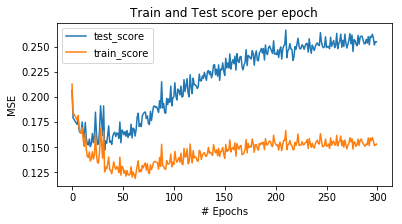

At optimal test scores: {'train_score': 0.12526095288434846, 'test_score': 0.14680677594983224}


,test_score,train_score,preprocessing,encoding,model
0,0.146807,0.125261,text_list,pretrained_word2vev,LSTM


In [104]:
pd.DataFrame(scores).plot(figsize=(6,3))
plt.title('Train and Test score per epoch')
plt.xlabel('# Epochs')
plt.ylabel('MSE')
plt.show()

min_idx = pd.DataFrame(scores).test_score.idxmin()
print('At optimal test scores: %s'%scores[min_idx])

lstm_comparison = pd.DataFrame([scores[min_idx]])
lstm_comparison['preprocessing'] = 'text_list'
lstm_comparison['encoding'] = 'pretrained_word2vev'
lstm_comparison['model'] = 'LSTM'

In [77]:
lstm_comparison = pd.DataFrame([{'train_score': 0.12526095288434846, 'test_score': 0.14680677594983224}])
lstm_comparison['preprocessing'] = 'text_list'
lstm_comparison['encoding'] = 'pretrained_word2vev'
lstm_comparison['model'] = 'LSTM'

# compare all model

In [81]:
tf_idf_model_comparison['model'] = 'SVM'
tf_idf_model_comparison['encoding'] = 'tf-idf'

w2v_model_comparison['model'] = 'SVM'
w2v_model_comparison['encoding'] = 'word2vec'

w2v_pretrained_model_comparison['model'] = 'SVM'
w2v_pretrained_model_comparison['encoding'] = 'pretrained_word2vec'

nrc_based_model_comparison['encoding'] = 'nrc_stats'
nrc_based_model_comparison['preprocessing'] = 'text_list'

naive_summary = pd.DataFrame([{'model':'naive_train_mean',
                          'test_score':mean_squared_error([train[target_col].mean()]*len(train), train[target_col]),
                          'train_score':mean_squared_error([train[target_col].mean()]*len(test), test[target_col])}])

svm_all_summary['encoding'] = 'multiple'
svm_all_summary['preprocessing'] = 'multiple'
svm_all_summary['model'] = 'SVM'

final_results = pd.concat([tf_idf_model_comparison,naive_summary,lstm_comparison,
w2v_model_comparison,
w2v_pretrained_model_comparison,
nrc_based_model_comparison, pd.DataFrame([svm_all_summary])]).fillna('')[['model','encoding','preprocessing','train_score','test_score']].sort_values('test_score')

print(final_results.to_latex(index=False))
final_results

C:\Users\orc\Anaconda2\envs\intro2ml\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



\begin{tabular}{lllrr}
\toprule
            model &             encoding &    preprocessing &  train\_score &  test\_score \\
\midrule
              SVM &             multiple &         multiple &     0.101752 &    0.119605 \\
              SVM &  pretrained\_word2vec &  text\_lower\_list &     0.096399 &    0.121023 \\
              SVM &  pretrained\_word2vec &       lemma\_list &     0.089756 &    0.121801 \\
              SVM &  pretrained\_word2vec &        text\_list &     0.094024 &    0.122627 \\
              SVM &               tf-idf &  text\_lower\_list &     0.022278 &    0.137354 \\
              SVM &            nrc\_stats &        text\_list &     0.118386 &    0.138060 \\
              SVM &               tf-idf &       lemma\_list &     0.018826 &    0.138323 \\
         AdaBoost &            nrc\_stats &        text\_list &     0.135012 &    0.138693 \\
              SVM &               tf-idf &        text\_list &     0.023333 &    0.139707 \\
     DecisionTree &   

,model,encoding,preprocessing,train_score,test_score
0,SVM,multiple,multiple,0.101752,0.119605
2,SVM,pretrained_word2vec,text_lower_list,0.096399,0.121023
0,SVM,pretrained_word2vec,lemma_list,0.089756,0.121801
1,SVM,pretrained_word2vec,text_list,0.094024,0.122627
3,SVM,tf-idf,text_lower_list,0.022278,0.137354
2,SVM,nrc_stats,text_list,0.118386,0.138060
0,SVM,tf-idf,lemma_list,0.018826,0.138323
1,AdaBoost,nrc_stats,text_list,0.135012,0.138693
2,SVM,tf-idf,text_list,0.023333,0.139707
0,DecisionTree,nrc_stats,text_list,0.131686,0.143816
